In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import pymc3 as pm

%matplotlib inline

In [49]:
senate = pd.read_csv('./data/senate.csv')

In [50]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612


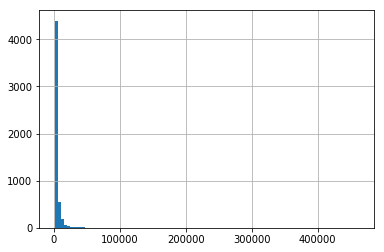

In [51]:
senate[senate['retweet_count'] > 1000].retweet_count.hist(bins=100)

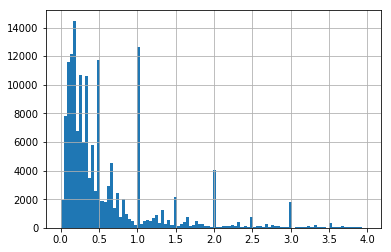

In [91]:
senate[(senate['the_ratio'] > 0) &(senate.the_ratio < 4)].the_ratio.hist(bins=100)

In [53]:
senate['z'] = np.log1p(senate.the_ratio)

In [54]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio,z
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667,0.510826
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321,0.454459
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418,0.151362
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766,0.155948
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612,0.211566


In [55]:
senate.describe()

,id_str,reply_count,retweet_count,the_ratio,z
count,2.195390e+05,219539.000000,219539.000000,219539.000000,219539.000000
mean,6.517680e+17,24.766652,137.181412,0.677336,0.361199
std,1.866934e+17,149.311035,1608.016919,1.847231,0.449842
min,2.299999e+09,0.000000,1.000000,0.000000,0.000000
25%,5.637520e+17,1.000000,3.000000,0.046512,0.045462
50%,7.054430e+17,2.000000,7.000000,0.250000,0.223144
75%,7.940000e+17,9.000000,22.000000,0.636364,0.492476
max,8.666520e+17,14230.000000,462572.000000,138.000000,4.934474


In [107]:
senate['the_ratio'].median()

0.25

In [109]:
senate[senate['party'] == 'Democratic'].the_ratio.median()

0.19642857142857145

In [110]:
senate[senate['party'] == 'Republican'].the_ratio.median()

0.3333333333333333

In [56]:
np.var(senate['the_ratio'])

3.4122469061637255

In [57]:
senate.the_ratio.mean()

0.6773362343539384

Gamma dist:

mean = alpha*Beta

Variance = alpha*(Beta**2)

### Getting the ratio for Democrats and Republicans

In [58]:
the_ratio_dem = senate[senate['party'] =='Democratic'].the_ratio.values
the_ratio_rep = senate[senate['party'] =='Republican'].the_ratio.values

In [71]:
print(the_ratio_dem.mean(), the_ratio_dem.var(), the_ratio_dem.std())
print(the_ratio_rep.mean(), the_ratio_rep.var(), the_ratio_rep.std())

0.37668160435989506 0.7342832379182765 0.8569032838764691
0.9539370092177968 5.682548775324917 2.3838097187747427


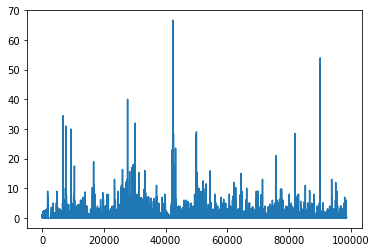

In [87]:
plt.plot(the_ratio_dem)

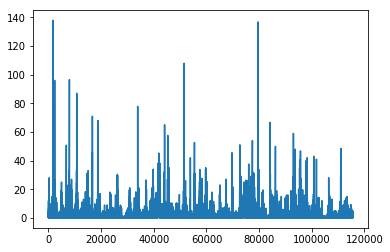

In [88]:
plt.plot(the_ratio_rep)

<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean the_ratio difference between groups.

In [60]:
tt = stats.ttest_ind(the_ratio_rep, the_ratio_dem)
print(tt.statistic)
print(tt.pvalue)

72.1505574553688
0.0


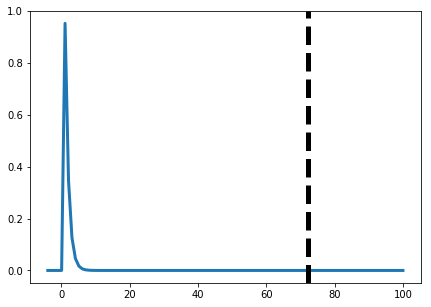

In [61]:
# THIS MAY OR MAYNOT BE USEFUL
zdist = stats.gamma(1,1)
xvals = np.linspace(-4, 100, 104)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xvals, zdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

<a id='priors'></a>
### Set up the bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of the_ratio regardless of partisanship. We can going to use these values to inform our prior belief about the_ratio.

In [62]:
prior_mean = senate.the_ratio.mean()
prior_std = senate.the_ratio.std()

print(prior_mean, prior_std)

0.6773362343539384 1.847231022102251


In [118]:
with pm.Model() as model:
    dem_mean = pm.Gamma('ratio_dem_mean', 
                         alpha = 0.134, 
                         beta = 5.039)
    rep_mean = pm.Gamma('ratio_rep_mean', 
                         alpha = 0.134, 
                         beta = 5.039)

In [119]:
# A: P(mu_apm, std_apm)
prior_std_lower = 0.000001
prior_std_upper = 100.0

with model:
    dem_std = pm.Uniform('ratio_dem_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)
    rep_std = pm.Uniform('ratio_rep_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)

In [120]:
# A: P(data | mu, std)
with model:
    dem = pm.Gamma('ratio_dem_like',
                    observed = the_ratio_dem,
                    alpha = pm.Normal('a_d_mean', mu=0.514, sd=.001),   
                    beta = pm.Normal('b_d_mean', mu=1.940, sd=.25))
    rep = pm.Gamma('ratio_rep_like',
                    observed = the_ratio_rep,
                    alpha = pm.Normal('a_r_mean', mu=0.168, sd=.001),   #0.168,
                    beta = pm.Normal('b_r_mean', mu=5.957, sd=.25))   #5.957)

/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/distributions/continuous.py:67: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/distributions/continuous.py:67: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [121]:
with model:
    diff_of_means = pm.Deterministic('mean_diff',
                                      rep_mean - dem_mean)
    diff_of_std = pm.Deterministic('std_diff',
                                    rep_std - dem_std)

In [122]:
# A:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start=start)
    #trace = pm.sample(10000,step)
    
    

logp = -inf, ||grad|| = 9.0674e+05: 100%|██████████| 3/3 [00:00<00:00, 207.14it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b_r_mean]
>Metropolis: [a_r_mean]
>Metropolis: [b_d_mean]
>Metropolis: [a_d_mean]
>Metropolis: [ratio_rep_std_interval__]
>Metropolis: [ratio_dem_std_interval__]
>Metropolis: [ratio_rep_mean_log__]
>Metropolis: [ratio_dem_mean_log__]
100%|██████████| 10500/10500 [04:02<00:00, 43.29it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d2362e8>,
      dtype=object)

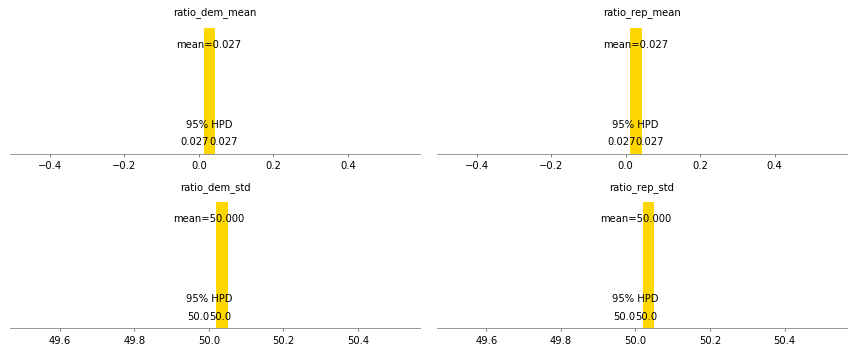

In [123]:
pm.plot_posterior(trace[1000:],
                  varnames=['ratio_dem_mean', 'ratio_rep_mean',
                            'ratio_dem_std', 'ratio_rep_std'],
                  color='#ffd700')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3ddb72b0>,
      dtype=object)

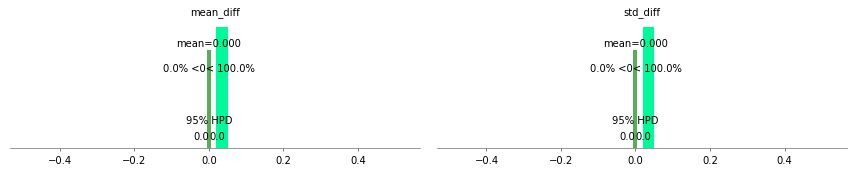

In [106]:
pm.plot_posterior(trace[1000:],
                  varnames=['mean_diff', 'std_diff'],
                  color='#00FA9A',
                  ref_val=0)

In [60]:
### nump.log1p - transform the ratio into 

## mean and variance of Z (new target variabe)

In [21]:
senate.z.mean(), senate.z.var()

(0.36119891517670105, 0.20235818469400238)

In [22]:
z_dem = senate[senate['party'] =='Democratic'].z.values
z_rep = senate[senate['party'] =='Republican'].z.values

print('Democrat', z_dem.mean(), z_dem.var())
print('Republican', z_rep.mean(), z_rep.var())

Democrat 0.25661434708288705 0.09123438607177879
Republican 0.4588512619374477 0.28339384664220113


In [23]:
tt = stats.ttest_ind(z_rep, z_dem)
print(tt.statistic)
print(tt.pvalue)

105.64033822739268
0.0


In [26]:
with pm.Model() as model:
    dem_mean = pm.Gamma('z_dem_mean', 
                         alpha = 0.645, 
                         beta = 0.560)
    rep_mean = pm.Gamma('z_rep_mean', 
                         alpha = 0.645, 
                         beta = 0.560)

In [27]:
# A: P(mu_apm, std_apm)
prior_std_lower = 0.000001
prior_std_upper = 100.0

with model:
    dem_std = pm.Uniform('z_dem_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)
    rep_std = pm.Uniform('z_rep_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)

In [28]:
with model:
    dem = pm.Gamma('z_dem_like',
                    observed = z_dem,
                    alpha = 0.726,
                    beta = 0.354)
    rep = pm.Gamma('z_rep_like',
                    observed = z_rep,
                    alpha = 0.744,
                    beta = 0.617)

In [29]:
with model:
    diff_of_means = pm.Deterministic('mean_diff',
                                      rep_mean - dem_mean)
    diff_of_std = pm.Deterministic('std_diff',
                                    rep_std - dem_std)

In [37]:
with model:
    #start = pm.find_MAP()
    step = pm.Metropolis()
    #trace_mp = pm.sample(5000, step, start=start)
    trace = pm.sample(10000, step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [z_rep_std_interval__]
>Metropolis: [z_dem_std_interval__]
>Metropolis: [z_rep_mean_log__]
>Metropolis: [z_dem_mean_log__]
100%|██████████| 10500/10500 [00:07<00:00, 1394.67it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
trace[0]

{'mean_diff': 0.0,
 'std_diff': 0.0,
 'z_dem_mean': 1.1517857142857142,
 'z_dem_mean_log__': 0.14131353306657748,
 'z_dem_std': 50.0000005,
 'z_dem_std_interval__': 0.0,
 'z_rep_mean': 1.1517857142857142,
 'z_rep_mean_log__': 0.14131353306657748,
 'z_rep_std': 50.0000005,
 'z_rep_std_interval__': 0.0}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20b044e0>,
      dtype=object)

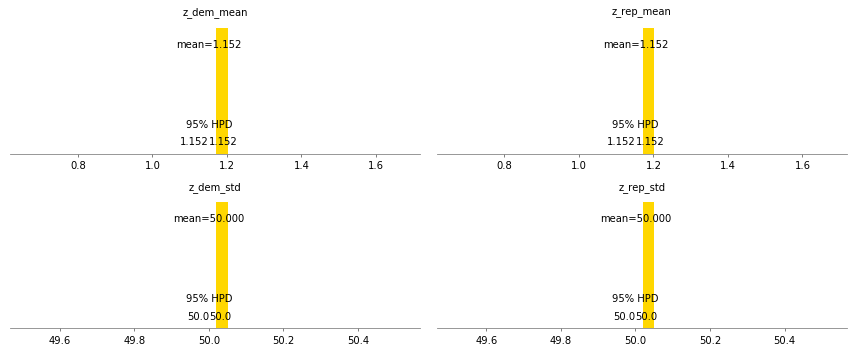

In [39]:
pm.plot_posterior(trace[1000:],
                  varnames=['z_dem_mean', 'z_rep_mean',
                            'z_dem_std', 'z_rep_std'],
                  color='#ffd700')